In [68]:
import os
from os.path import abspath, join
import pandas as pd
from sklearn import metrics
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [3]:
# Stablish working directory
os.chdir("..")
os.getcwd()

In [59]:
# Read predictions
pred_path = abspath("predictions/prediction.csv")
pred_df = pd.read_csv(pred_path)
pred_df.shape

(2718, 3)

In [ ]:
def plot_auc_curve(trues, probabilities, title=None, save=None, show=False):
    """
    Plots the ROC AUC curve for two vectors,
    one with the true labels and one with the predicted probabilites

    :param (numpy.ndarray) trues: Array with the true labels
    :param (numpy.ndarray) probabilities: Array with the predicted labels.
    :param (string) title: Title of the plot.
    :param (string) save: Path for output example file.
    :param (boolean) show: Flag to show or not the figure.
    :return: Saves the sample figure to an specified path or shows it.
    """
    # Calculate fpr and tpr
    fpr, tpr, thr = roc_curve(trues, probabilities)
    roc_auc = auc(fpr, tpr)

    # Create canvas
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    # Plot
    lw = 3
    sns.lineplot(x=fpr, y=tpr, lw=lw, label=f'area = {roc_auc:.4f}', ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], lw=lw, linestyle='--', ax=ax)

    # A E S T H E T I C S
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    sns.despine(left=True, bottom=True)
    ax.set_xlabel('False Positive Rate (1-Specificity)', fontsize=15)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    plt.legend(loc="lower right", fontsize=15)

    # Title
    if title is not None:
        ax.set_title(title, fontsize= 20)
    else:
        ax.set_title('ROC curve', fontsize = 20)

    # Show
    if show:
        fig.show()

    # Save
    if save is not None:
        plt.savefig(save, dpi=300)

In [39]:
pred_df.head()

,image,label,prediction
0,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0,0.008948
1,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0,0.000060
2,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0,0.000500
3,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0,0.000576
4,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0,0.000118


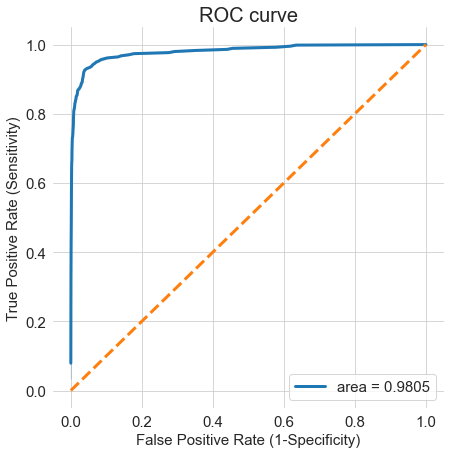

In [40]:
plot_auc_curve(pred_df["label"], pred_df["prediction"])

In [91]:
# Fix name
pred_df["file"] = pred_df.apply(lambda x: os.path.splitext(x.image.split(" - ")[0].split("_")[0])[0].replace("Snap-",""), axis=1)

In [129]:
# Load micronuclei per slide
ground_true = pd.read_table("micronucleiperslide.tsv")
ground_true = ground_true.dropna()
ground_true

,file,cells,micronuclei
0,a375,4,0
1,1972,13,2
2,1973,9,0
3,1974,7,1
4,1975,9,2
...,...,...,...
211,2359,9,1
212,2360,15,2
213,2361,18,3
214,2362,17,2


In [130]:
# Counting predicted micronuclei per slide/well
predicted_micronuclei_perwell = pd.concat([pd.Series([i, d.shape[0], (d["prediction"] > 0.5).astype(int).sum()]) for i,d in pred_df.groupby("file")], axis=1).T
predicted_micronuclei_perwell = predicted_micronuclei_perwell.rename(columns={0:"file", 1:"cells", 2:"micronuclei"})
predicted_micronuclei_perwell

,file,cells,micronuclei
0,1974,9,1
1,1975,9,4
2,1976,7,2
3,1977,7,3
4,1978,8,1
...,...,...,...
201,2396,16,0
202,2398,17,0
203,2399,7,2
204,2400,6,0


In [159]:
f_in_common = pd.merge(predicted_micronuclei_perwell, ground_true, "inner", on="file")
f_in_common

,file,cells_x,micronuclei_x,cells_y,micronuclei_y
0,1974,9,1,7,1
1,1975,9,4,9,2
2,1976,7,2,10,1
3,1977,7,3,7,1
4,1978,8,1,8,2
...,...,...,...,...,...
157,2396,16,0,18,2
158,2398,17,0,21,0
159,2399,7,2,9,4
160,2400,6,0,8,0


In [160]:
# Check how the number of predicted cells differ
print("Cell differece std",(f_in_common["cells_x"] - f_in_common["cells_y"]).std())
print("Cell differece mean",(f_in_common["cells_x"] - f_in_common["cells_y"]).mean())

Cell differece std 3.9710631878385683
Cell differece mean 0.20987654320987653


In [163]:
print(f_in_common[f_in_common["cells_x"] - f_in_common["cells_y"] == 0].shape)
print(f_in_common[f_in_common["cells_x"] - f_in_common["cells_y"] != 0].shape)

(42, 5)
(120, 5)


In [165]:
# Check how the number of predicted cells differ
print("Micronuclei differece std",(f_in_common["micronuclei_x"] - f_in_common["micronuclei_y"]).std())
print("Micronuclei differece mean",(f_in_common["micronuclei_x"] - f_in_common["micronuclei_y"]).mean())

Micronuclei differece std 1.7548119783512648
Micronuclei differece mean 0.037037037037037035


In [166]:
print(f_in_common[f_in_common["micronuclei_x"] - f_in_common["micronuclei_y"] == 0].shape)
print(f_in_common[f_in_common["micronuclei_x"] - f_in_common["micronuclei_y"] != 0].shape)

(55, 5)
(107, 5)


In [170]:
print("Total micronuclei predicted: ", f_in_common["micronuclei_x"].sum())
print("Total micronuclei ground truth: ", f_in_common["micronuclei_y"].sum())

Total micronuclei predicted:  284
Total micronuclei ground truth:  278
